In [68]:
import numpy as np
from commpy import PSKModem, QAMModem
from matplotlib import pyplot as plt
from matplotlib import pyplot

In [69]:
#
# Set up the constellation and some constants for QPSK
##
nsymbols=4
repeats_per_symbol = 16
samples_per_second = 1000
message_len = 3000
total_samples = repeats_per_symbol*message_len
baseband_carrier_freq = 10
noise_sd = 0.01

duration = total_samples/samples_per_second
time = np.linspace(0,duration, total_samples)/samples_per_second # clock time of each sample

[0.00000000e+00 1.00002083e-06 2.00004167e-06 3.00006250e-06
 4.00008334e-06 5.00010417e-06 6.00012500e-06 7.00014584e-06
 8.00016667e-06 9.00018750e-06]
(1.0000000000000002+0j)
(0.9999999999999998+0j)


<IPython.core.display.Javascript object>


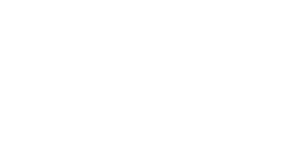

<IPython.core.display.Javascript object>


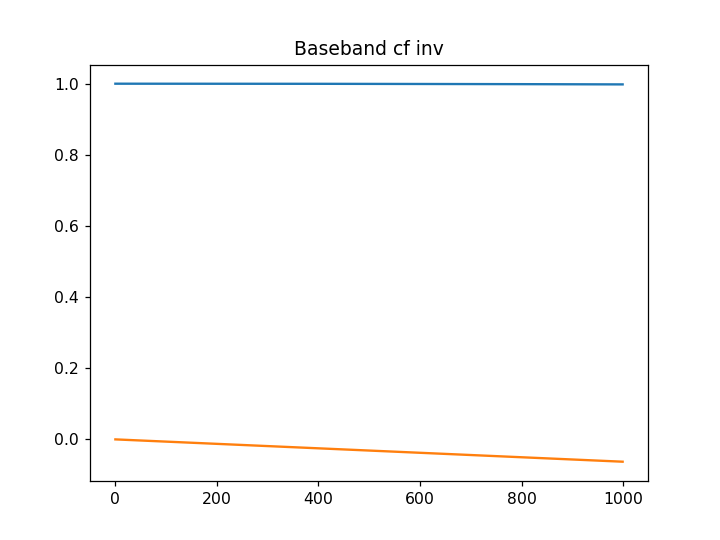

In [70]:

#
# Setup the baseband
#
print(time[:10])
baseband_signal =  np.exp(1j*2*np.pi*time*(baseband_carrier_freq))

baseband_inv = np.exp(-1j*2*np.pi*time*(baseband_carrier_freq))

time_shift = 0.001
bad_baseband_inv = np.exp(-1j*2*np.pi*((time+time_shift)*baseband_carrier_freq))

assert np.all(np.abs(baseband_signal*baseband_inv) -1. < 0.00001)
print(np.max(baseband_signal*baseband_inv))
print(np.min(baseband_signal*baseband_inv))

#
# This inverses may not match intuition. Probably they
# would if we plotted a dot rotating on a circle,
# but do note that we mathematically asserted
# the composition of the two functions is 1, which is the definition of inverse.
#
pyplot.close("all")
pyplot.plot(np.real(baseband_signal[:1000]))
pyplot.plot(np.imag(baseband_signal[:1000]))
pyplot.title("Baseband cf")
pyplot.show()

pyplot.close("all")
pyplot.title("Baseband cf inv")
pyplot.plot(np.real(baseband_inv[:1000]))
pyplot.plot(np.imag(baseband_inv[:1000]))
pyplot.show()

<IPython.core.display.Javascript object>


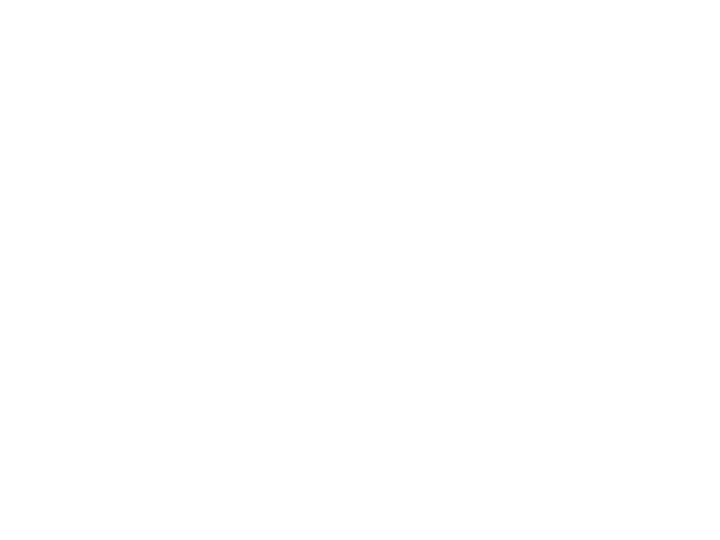

C:\Users\babc226\Anaconda3\envs\py38i\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


<IPython.core.display.Javascript object>


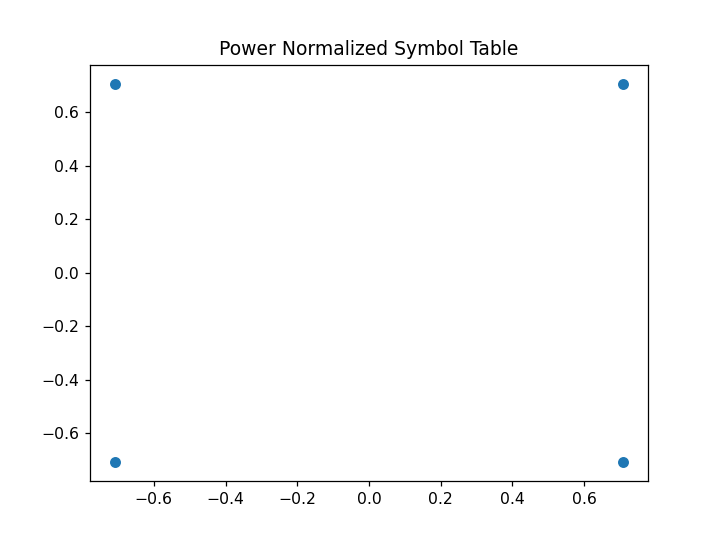

In [71]:





m = QAMModem(nsymbols)
con = m.constellation
con = con/np.max(np.abs(con))  # power normalizing


#
# There is non-unit amplitude in this constellation plot which can cause issues.
#
pyplot.close("all")
m.plot_constellation()
con
pyplot.close("all")
pyplot.scatter(np.real(con), np.imag(con))
pyplot.title("Power Normalized Symbol Table")
pyplot.show()

In [72]:
symbol_message = np.random.randint(0, nsymbols, message_len)
symbol_message[:10]
message_with_repeats = np.repeat(symbol_message, repeats_per_symbol)
print(message_with_repeats[:30])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [73]:
#
# An IQ encoding of a message is just a symbol lookup table
#

iq_encoded_message = con[message_with_repeats]
iq_encoded_message

#
#
#

array([-0.70710678+0.70710678j, -0.70710678+0.70710678j,
       -0.70710678+0.70710678j, ..., -0.70710678-0.70710678j,
       -0.70710678-0.70710678j, -0.70710678-0.70710678j])

<IPython.core.display.Javascript object>


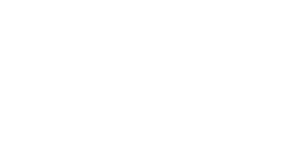

<IPython.core.display.Javascript object>


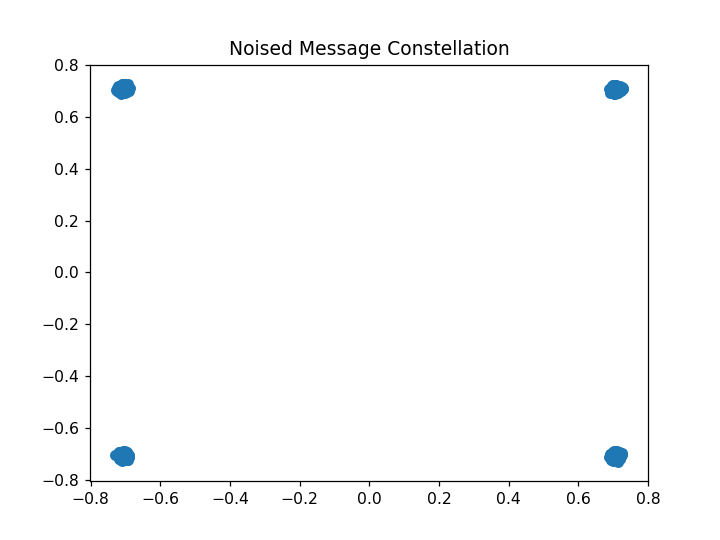

In [74]:
#
# Modulate the encoding unto the baseband cf
#
modulated = iq_encoded_message*baseband_signal
#
# Create noise for our channel model
#
noise = np.random.normal(0,noise_sd/np.sqrt(2),len(iq_encoded_message)) +  1.j*np.random.normal(0,noise_sd/np.sqrt(2), len(iq_encoded_message))
#
# Channel refers to the idea of a channel model with experimental effects.  Here AWGN.
#
channel_iq = modulated + noise

plt.close("all")
plt.scatter(np.real(channel_iq[:1000]), np.imag(channel_iq[:1000]))
plt.title("Noised Message Constellation")
plt.show()
#
# Unmodulate with baseband inv to get the original modulation with noise effects
#
unmodulated = channel_iq*baseband_inv
plt.close("all")
plt.scatter(np.real(unmodulated[:1000]), np.imag(unmodulated[:1000]))
plt.title("Noised Message Constellation")
plt.show()

<IPython.core.display.Javascript object>


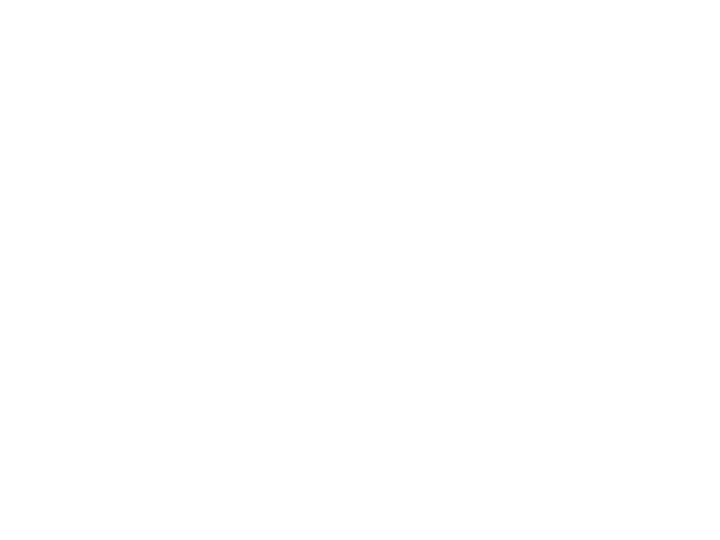

<IPython.core.display.Javascript object>


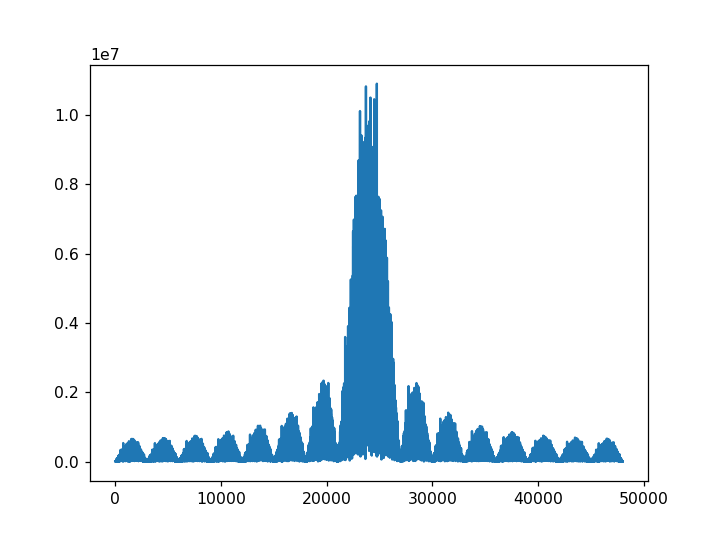

In [75]:
fftLen = len(modulated)  # perform 4-times zeropadding to get smoother spectrum
spectrum = lambda x: np.fft.fftshift(np.fft.fft(x, fftLen)) / baseband_carrier_freq * (len(modulated))
pyplot.close("all")
pyplot.specgram(modulated,Fs=baseband_carrier_freq)
pyplot.xlabel("Time")
pyplot.ylabel("Frequency")
pyplot.show()
#
# Pretty sure my units are screwed up here...
#
f = spectrum(channel_iq)
pyplot.close("all")
pyplot.plot(np.abs(f))
pyplot.show()

<IPython.core.display.Javascript object>


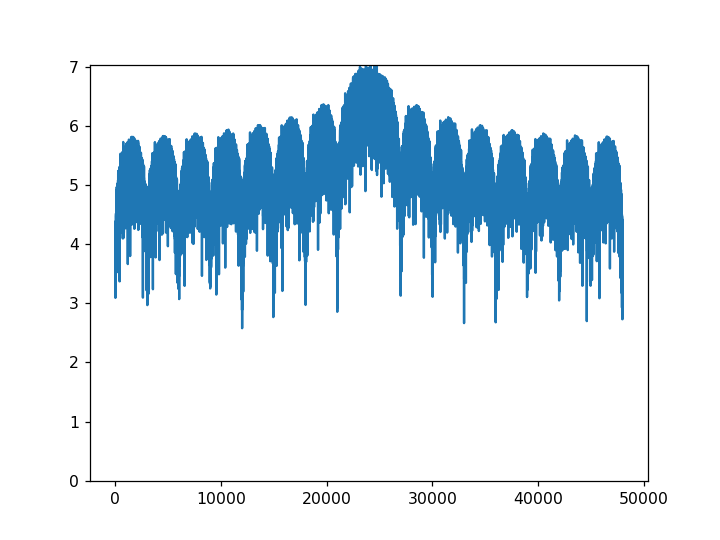

In [76]:
pyplot.close("all")
p = np.log10(np.abs(f))
pyplot.plot(p)
pyplot.ylim([0,np.max(p)])
pyplot.show()

48000


<IPython.core.display.Javascript object>


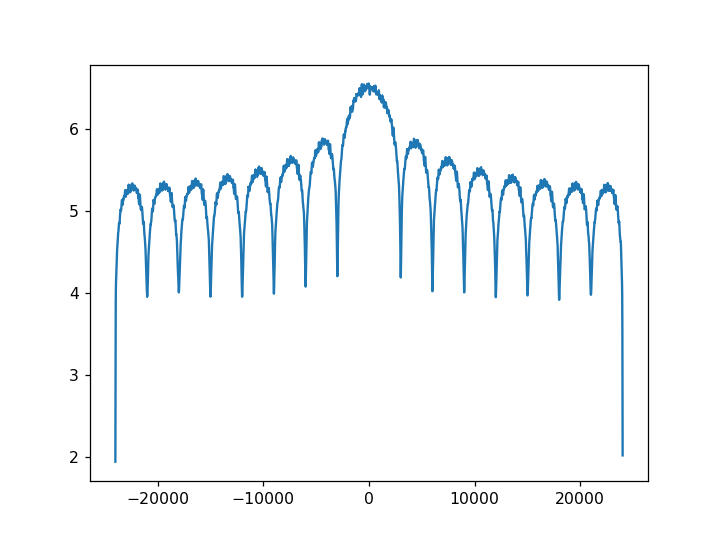

In [77]:
pyplot.close("all")
p = np.log10(np.abs(f))
hammer = np.hamming(100)
hammer = hammer/np.sum(hammer)
pc = np.convolve(p, hammer,mode="same")
pt = np.linspace(-len(modulated)/2, len(modulated)/2, len(modulated))
print(len(modulated))
pyplot.plot(pt,pc)
pyplot.show()

48000


<IPython.core.display.Javascript object>


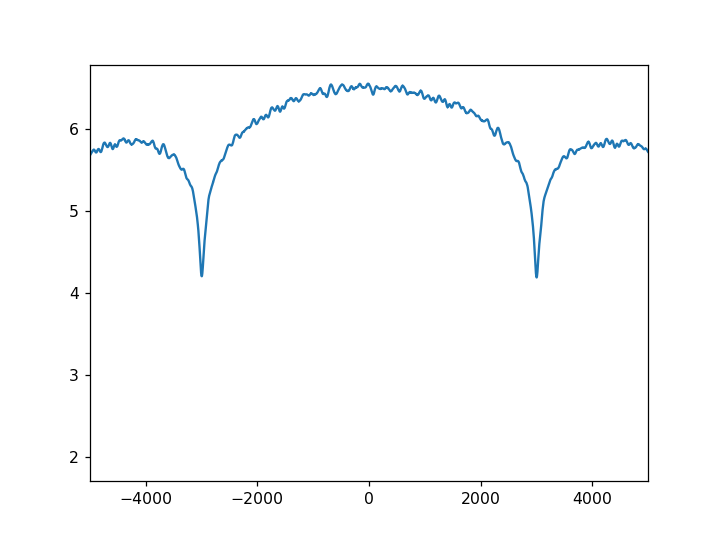

In [78]:
pyplot.close("all")
p = np.log10(np.abs(f))
hammer = np.hamming(100)
hammer = hammer/np.sum(hammer)
pc = np.convolve(p, hammer,mode="same")
pt = np.linspace(-len(modulated)/2, len(modulated)/2, len(modulated))
print(len(modulated))
pyplot.plot(pt,pc)
pyplot.xlim([-5000,5000])
pyplot.show()

[   0  214  428  642  857 1071 1285 1500 1714 1928 2142 2357 2571 2785
 3000]


<IPython.core.display.Javascript object>


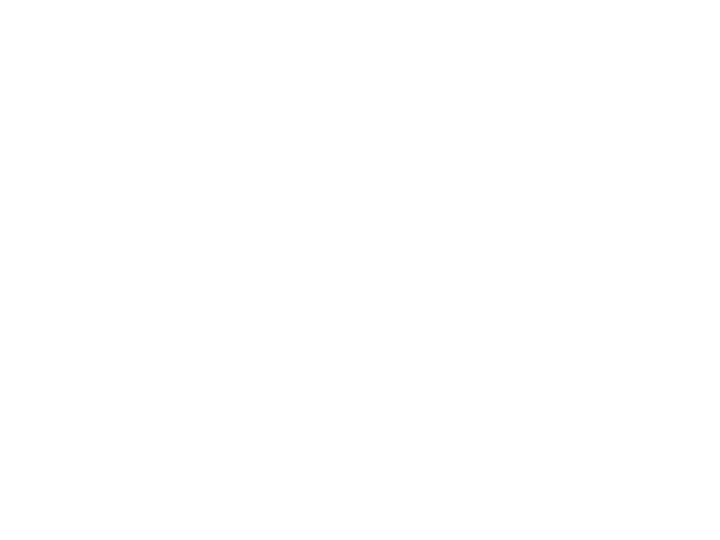

<IPython.core.display.Javascript object>


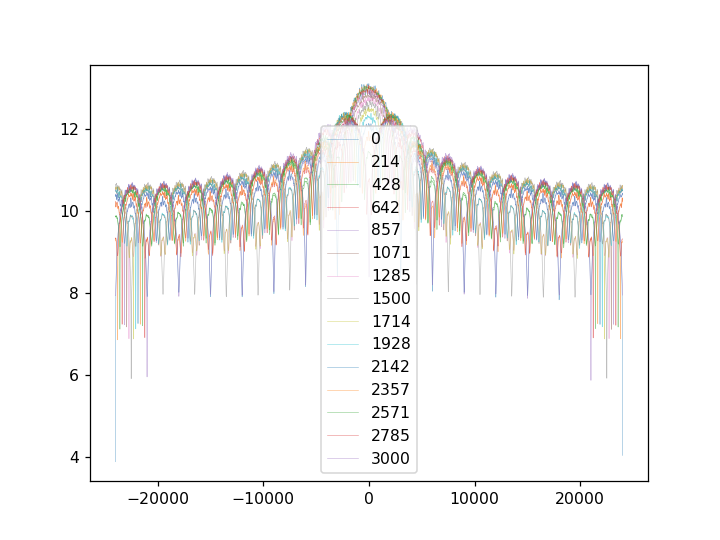

                  0           750          1500          2250          3000
count  48000.000000  48000.000000  48000.000000  48000.000000  48000.000000
mean       6.183146      6.076210      6.179114      6.076218      6.179189
std        1.005763      0.797740      0.959512      0.732205      0.910457
min        3.087538      4.665989      3.339867      4.652371      3.059533
25%        5.698630      5.611421      5.720761      5.626831      5.750723
50%        6.159753      5.857404      6.176762      5.876027      6.195827
75%        6.615718      6.362692      6.664732      6.419983      6.724062
max        8.625565      8.451417      8.228002      7.861690      7.800388


In [82]:
#
# This one looks closer to right to me
#
%matplotlib notebook 

rotated_fft_alpha = np.linspace(0, 3000, 15).astype(int)
print(rotated_fft_alpha)
pyplot.close("all")
data = {}
for r in rotated_fft_alpha:
    right_rolled = np.roll(pc,r)
    left_rolled = np.roll(pc,-r)
    pc_rolled = right_rolled+left_rolled
    pyplot.plot(pt, pc_rolled, label=str(r), alpha=0.5)
    data[str(r)] = pc_rolled
    
pyplot.legend()
pyplot.ylim([0, 60])
pyplot.show()
import pandas as pd

df1 = pd.DataFrame(data)
df1.index = pt
pyplot.close("all")
df1.plot(linewidth=0.4, alpha=0.5)
plt.show()
print(df.describe())


<IPython.core.display.Javascript object>


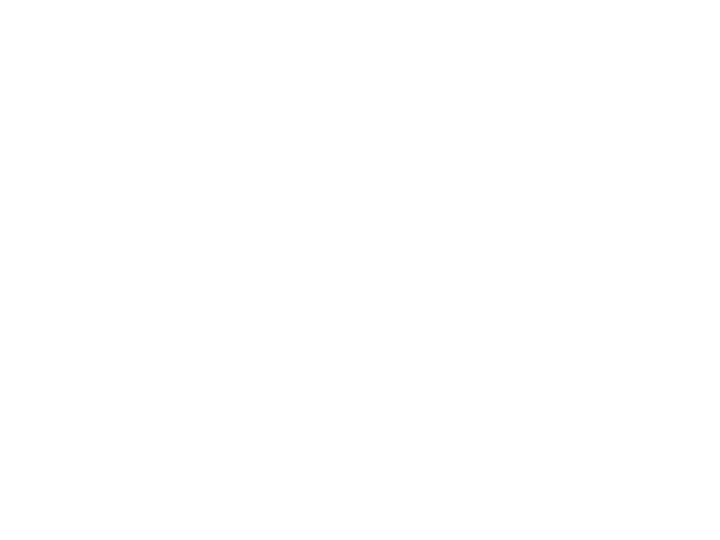

<IPython.core.display.Javascript object>


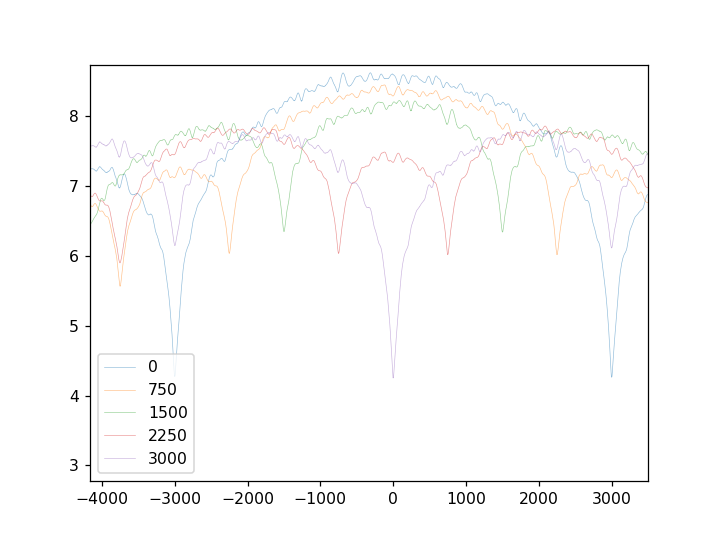

                  0           750          1500          2250          3000
count  48000.000000  48000.000000  48000.000000  48000.000000  48000.000000
mean       6.183146      6.076210      6.179114      6.076218      6.179189
std        1.005763      0.797740      0.959512      0.732205      0.910457
min        3.087538      4.665989      3.339867      4.652371      3.059533
25%        5.698630      5.611421      5.720761      5.626831      5.750723
50%        6.159753      5.857404      6.176762      5.876027      6.195827
75%        6.615718      6.362692      6.664732      6.419983      6.724062
max        8.625565      8.451417      8.228002      7.861690      7.800388
                  0           750          1500          2250          3000
count  48000.000000  48000.000000  48000.000000  48000.000000  48000.000000
mean       1.735107      1.756665      1.735722      1.755325      1.734294
std        0.128791      0.088542      0.130481      0.084873      0.127274
min        1

'\npyplot.close("all")\ndiff_df.plot(linewidth=0.4, alpha=0.5)\nplt.show()\n'

In [81]:
#
# This looks Wrong... Fixed with a conjugate and log10 after convolution 

#
# ff = np.convolve(f, hammer,mode="same")

rotated_fft_alpha = np.linspace(0, 3000, 5).astype(int)
data = {}
N = f.size
for r in rotated_fft_alpha:
    left_rolled_f = np.roll(f, r)
    right_rolled_f = np.roll(f, -r)
    f_rolled = right_rolled_f*np.conj(left_rolled_f)/N
    p_rolled = np.abs(f_rolled)
    pc_rolled = np.log10(np.convolve(p_rolled, hammer, "same"))
    pyplot.plot(pt, pc_rolled, label=str(r), alpha=0.5)
    data[str(r)] = pc_rolled
    

df = pd.DataFrame(data)
df.index = pt


pyplot.close("all")
df.plot(linewidth=0.4, alpha=0.5)
plt.show()

print(df.describe())

diff_df = np.abs(df1/df)
print(diff_df.describe())
'''
pyplot.close("all")
diff_df.plot(linewidth=0.4, alpha=0.5)
plt.show()
'''